## Examen Segundo Parcial - Visión para robots
---

#### **Instrucciones** 

1. Lee el notebook completo antes de iniciar.
2. Contesta las celdas de preguntas directamente en el notebook.
3. Para las partes de código, agrega todas las celdas de código que consideres necesarias.
4. El notebook se entrega en Canvas. **Garantiza que hayas ejecutado todas las celdas de código antes de subirlo.**

### Preguntas de código
---

Imports básicos y ruta de las imágenes de prueba.

In [13]:
import cv2 
import numpy as np
import matplotlib.pyplot as plt

#### Ejercicio 1 (45 puntos)

Desarrolla un pipeline de gráficas para convertir la imagen **woman.jpg**:

![Examen 1](images/woman.jpg)

en la siguiente:

![Examen 2](images/woman_final.png)

El fondo es el mismo que la primer imagen, y solo cambia la mujer que aparece. La mujer cambia a tener menos colores, y se dibuja el contorno encima de la mujer.

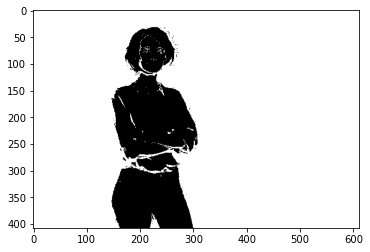

In [14]:
# Pregunta 1

woman = cv2.imread('images/woman.jpg')
woman = cv2.cvtColor(woman, cv2.COLOR_BGR2RGB)

# Creamos la mascara con los azules de la imagen
lower_blue = np.array([0, 57, 74]) 
upper_blue = np.array([184, 229, 242])

mask = cv2.inRange(woman, lower_blue, upper_blue)

plt.imshow(mask, cmap='gray')

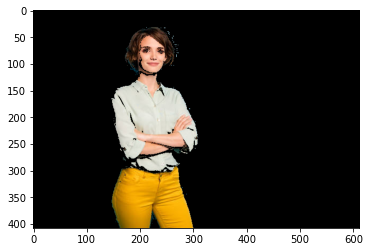

In [15]:
# Aplicamos la mascara
masked_image = np.copy(woman)
masked_image[mask != 0] = [0, 0, 0]
plt.imshow(masked_image)

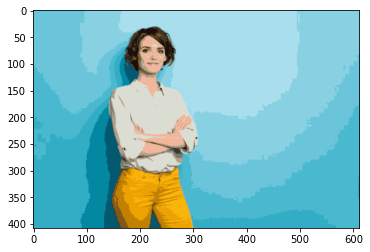

In [16]:
# Usamos Kmeans clustering

woman_copy = np.copy(woman)

pixel_vals = woman_copy.reshape((-1,3))
pixel_vals = np.float32(pixel_vals)

criteria = (cv2.TERM_CRITERIA_MAX_ITER + cv2.TERM_CRITERIA_EPS, 10, 1.0)

k = 17
retval, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 5, cv2.KMEANS_RANDOM_CENTERS)

centers = np.uint8(centers)
segmented_data = centers[labels.flatten()]

segmented_image = segmented_data.reshape((woman_copy.shape))

plt.imshow(segmented_image, cmap="gray")

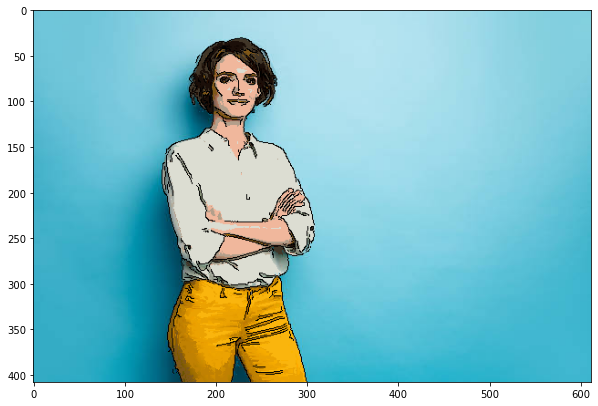

In [17]:
# Hacemos canny y se lo aplicamos a nuestra imagen final

image_result = np.copy(woman)

woman_edges = cv2.Canny(woman_copy, 120, 240)

for i in range(woman_copy.shape[0]):
        for j in range(woman_copy.shape[1]):
            if(masked_image[i, j, 0] != 0 and masked_image[i, j, 1] != 0 and masked_image[i, j, 2] != 0):
                image_result[i, j, 0] = segmented_image[i, j, 0]
                image_result[i, j, 1] = segmented_image[i, j, 1]
                image_result[i, j, 2] = segmented_image[i, j, 2]
            if(woman_edges[i, j] != 0):
                image_result[i, j, 0] = 0
                image_result[i, j, 1] = 0
                image_result[i, j, 2] = 0

f, (ax1) = plt.subplots(1, 1, figsize=(10,10))
ax1.imshow(image_result, cmap='gray')

#### Ejercicio 2 (20 puntos)

Utilizando [Haar Cascade Classifiers](https://github.com/opencv/opencv/tree/master/data/haarcascades), detecta gatos en las imágenes **cat1.jpg**, **cat2.jpg**, y **cat3.jpg**. Dibuja un círculo encima de la cara de los gatos. **NOTA** Hay gatos en todas las imágenes, y en **cat3.jpg** hay varios gatos.

In [18]:
# Ejercicio 2

# Cargamos el haar cascade de frontalcatface
cat_cascade = cv2.CascadeClassifier()
if not cat_cascade.load('haar_cascades/haarcascade_frontalcatface.xml'):
    print("Error loading cascade classifier")
else:
    print("Classifier loaded correctly")

Classifier loaded correctly


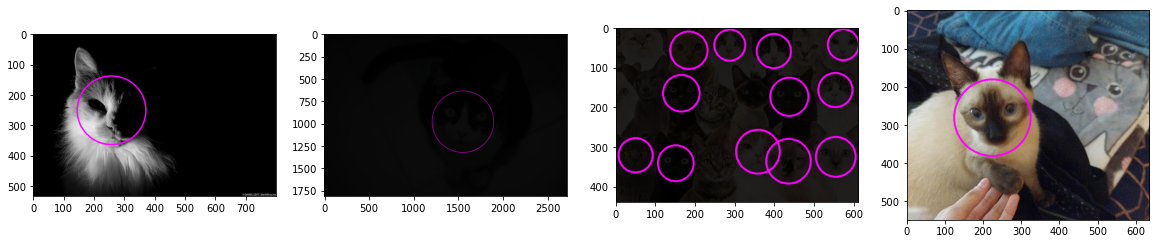

In [19]:
cat_images = []
cat_gray_images = []

f, ax = plt.subplots(1, 4, figsize=(20,10))

# Cargamos las fotos de los gatos para ecualizarlas y detectar sus caras con el cascade
# Adjunto foto de mi michi para ver si la detecta
for i in range(4):
    cat = cv2.imread(f'images/cats/cat{i+1}.jpg')

    cat = cv2.cvtColor(cat, cv2.COLOR_BGR2RGB)
    cat_gray = cv2.cvtColor(cat, cv2.COLOR_RGB2GRAY)
    eq = cv2.equalizeHist(cat_gray)

    cat_images.append(cat)
    cat_gray_images.append(cat_gray_images)

    faces = cat_cascade.detectMultiScale(eq)

    for (x,y,w,h) in faces:
        center = (x + w//2, y + h//2)
        cat_faces = cv2.ellipse(cat, center, (w//2, h//2), 0, 0, 360, (255, 0, 255), 4)
        sub_face = cat[y:y+h, x:x+w]
        cat[y:y+sub_face.shape[0], x:x+sub_face.shape[1]] = sub_face

    ax[i].imshow(cat_images[i], cmap='gray')

#### Ejercicio 3 (35 puntos)

Crea un pipeline de visión para calificar automáticamente un examen de opción múltiple. Utiliza la imagen **Bubble_test.png**

![Expected output](images/Bubble_test.png)

El resultado esperado es que se detecten las respuestas seleccionadas:

![Expected output](images/Bubble_test_solved.png)

y que calcule y muestre la calificación asumiendo que las respuestas del examen son las siguientes:

1. A
2. B
3. B
4. C
5. A
6. A
7. B
8. B
9. C
10. D

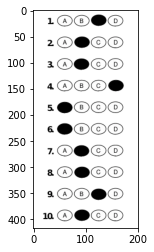

In [20]:
# Pregunta 3

# Creamos diccionario con el rango de coordenadas de las opciones y un arreglo de las respuestas correctas
opciones = {'A':(130, 210), 'B':(240, 320), 'C':(330, 420), 'D':(430, 520)}
respuestas = ['A', 'B', 'B', 'C', 'A', 'A', 'B', 'B', 'C', 'D']

test = cv2.imread('images/Bubble_test.png')
test = cv2.cvtColor(test, cv2.COLOR_BGR2RGB)

plt.imshow(test)

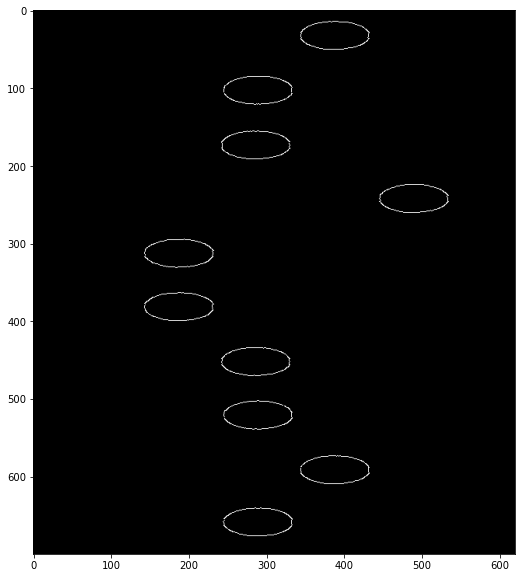

In [21]:
test_copy = np.copy(test)
test_copy = cv2.resize(test_copy, (620,700))
test_gray = cv2.cvtColor(test_copy, cv2.COLOR_RGB2GRAY)

# Hacemos un blur para eliminar otras areas de la imagen y resaltar las respuestas seleccionadas con canny
blur = cv2.GaussianBlur(test_gray, (27,27), 0)
edges = cv2.Canny(blur, 120, 230)
retval, binary = cv2.threshold(edges, 0, 255, cv2.THRESH_OTSU)

f, (ax1) = plt.subplots(1, 1, figsize=(10,10))
ax1.imshow(binary, cmap='gray')

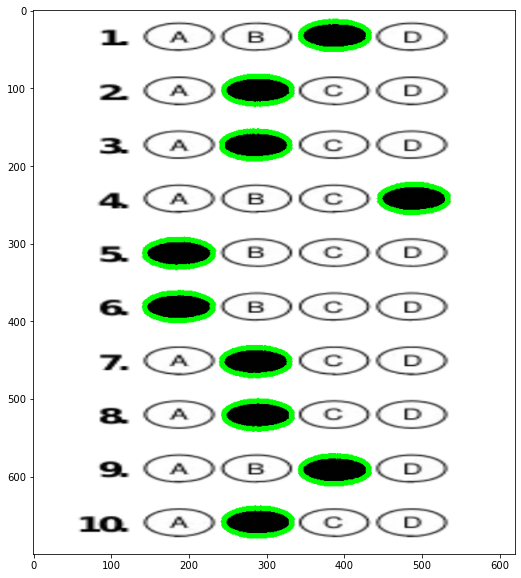

In [22]:
# Dibujamos los contornos a partir del canny
(contours, _) = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

all_contours = cv2.drawContours(test_copy, contours, -1, (0,255,0), 5)

f, (ax1) = plt.subplots(1, 1, figsize=(10,10))
ax1.imshow(all_contours, cmap='gray')

In [23]:
# Calculamos los centroides

centroides = []
for idx, selected_contour in enumerate(contours):
    if(selected_contour is not None):
        moments = cv2.moments(selected_contour)

        cx = int(moments['m10']/moments['m00'])
        cy = int(moments['m01']/moments['m00'])

        centroides.append((cx, cy))

# Se eliminan valores repetidos de centroides
centroides.pop(3)
centroides.pop(6)
centroides.pop(8)
centroides.pop(10)

(387, 32)

In [24]:
calificacion = 0

# Recorremos los centroides y hacemos una comparacion con las coordenadas de las opciones
for x in range(len(centroides)):
    if (respuestas[x] == 'A' and centroides[9-x][0] >= opciones['A'][0] and centroides[9-x][0] <= opciones['A'][1]):
        calificacion += 10
    elif (respuestas[x] == 'B' and centroides[9-x][0] >= opciones['B'][0] and centroides[9-x][0] <= opciones['B'][1]):
        calificacion += 10
    elif (respuestas[x] == 'C' and centroides[9-x][0] >= opciones['C'][0] and centroides[9-x][0] <= opciones['C'][1]):
        calificacion += 10
    elif (respuestas[x] == 'D' and centroides[9-x][0] >= opciones['D'][0] and centroides[9-x][0] <= opciones['D'][1]):
        calificacion += 10

print('La calificacion es de', calificacion)

La calificacion es de 70
